### Análisis exploratorio de datos

#### Importación de librerias


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [4]:
with open("../dataset/data.pkl", "rb") as file:
    df = pickle.load(file)

In [5]:
# Información del dataFrame 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39105 entries, 0 to 39104
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   label    39105 non-null  category
 1   content  39105 non-null  object  
dtypes: category(1), object(1)
memory usage: 343.8+ KB


#### Dimensiones del DataFrame

In [6]:
#Dimensiones del DataFrame
print('Cantidad de Filas y columnas:',df.shape)
print('Nombre de columnas:',df.columns)

Cantidad de Filas y columnas: (39105, 2)
Nombre de columnas: Index(['label', 'content'], dtype='object')


In [7]:
# Conteo de valores únicos en la columna 'label'
print(df['label'].value_counts())

label
1    21197
0    17908
Name: count, dtype: int64


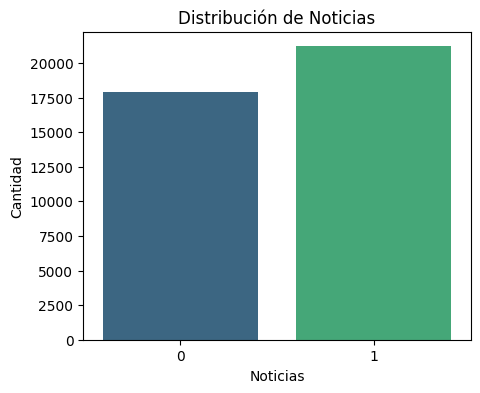

In [8]:
# Visualización de la distribución de etiquetas
plt.figure(figsize=(5, 4))
sns.countplot(x='label', data=df,  palette='viridis')
plt.ylabel('Cantidad')
plt.xlabel('Noticias')
plt.title('Distribución de Noticias')
plt.show()

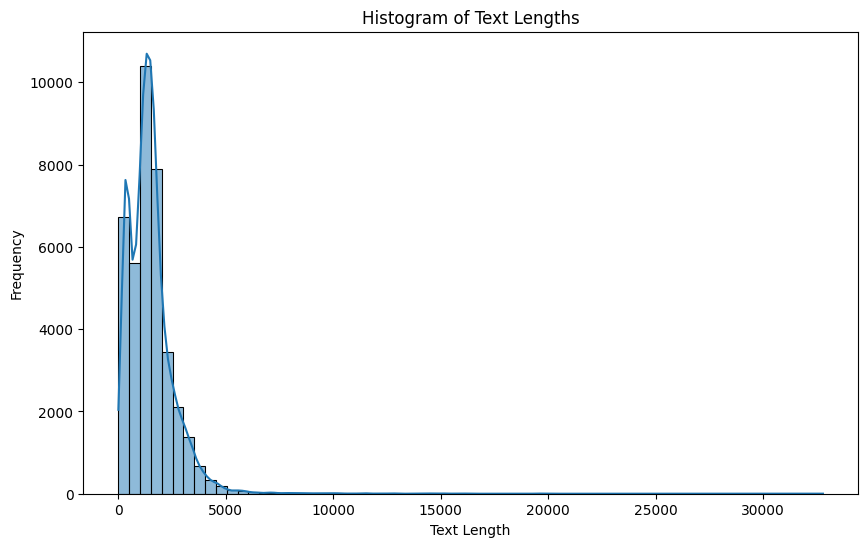

In [9]:
# Longitud de los textos en la columna 'content'
df['content_length'] = df['content'].apply(len)

# Histograma de la longitud de los textos
plt.figure(figsize=(10, 6))
sns.histplot(df['content_length'], bins=65, kde=True, palette='husl')
plt.title('Histogram of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

De acuerdo al gráfico se puede indicar lo siguiente:

-La distribución se apila al lado izquierdo y tiene una "cola" alargada a la derecha, por lo que es claro que la distribución es sesgada a la derecha.

-La distribución es claramente unimodal, ya que un pico de la longitud de Texto esta en entre 0 y 2000.

-Existe un dato extremadamente atípico sucede en alrededor de la longitud de Texto de 35000.


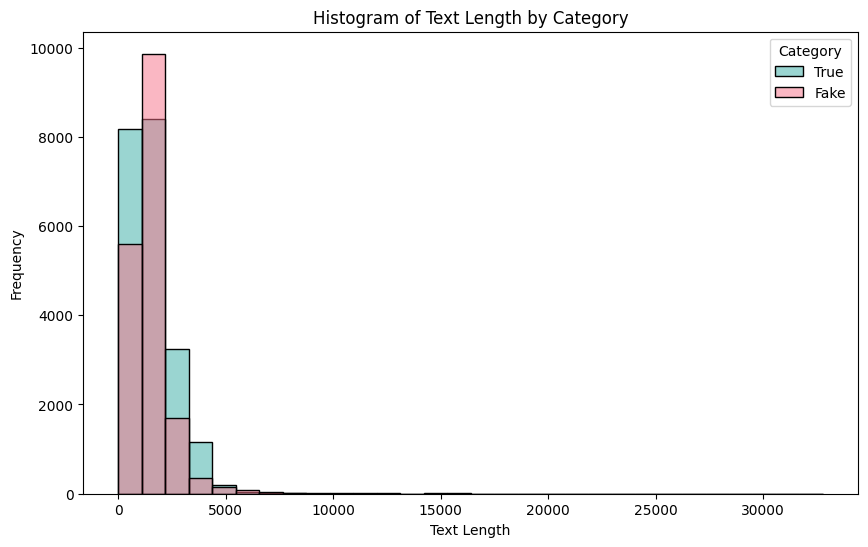

In [10]:
# Histograma de longitud del texto por categoría
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='content_length', hue='label', bins=30, kde=False, palette='husl')
plt.title('Histogram of Text Length by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Category', labels=['True', 'Fake'])
plt.show()

- Las noticias falsas tienen una mayor concentración de longitudes de texto en el rango de 0 a 2500 y el rango superior a 5000, mientras que las noticias verdaderas muestran una concentración en el rango de 2500 a 5000. Esto sugiere que las noticias verdaderas tienden a tener textos de longitud media, mientras que las noticias falsas tienden a tener textos más cortos y muy largos por lo que están centrados en el rango inferior y superior.

In [11]:
import pandas as pd

# Definir los bins basados en la longitud del texto
bins = range(0, df['content_length'].max() + 100, 100)

# Crear los bins y contar la frecuencia de cada bin
frecuencia_por_rango = pd.cut(df['content_length'], bins=bins).value_counts().sort_index()

print(frecuencia_por_rango)


content_length
(0, 100]           617
(100, 200]         662
(200, 300]        1082
(300, 400]        2230
(400, 500]        1819
                  ... 
(32300, 32400]       0
(32400, 32500]       0
(32500, 32600]       0
(32600, 32700]       0
(32700, 32800]       1
Name: count, Length: 328, dtype: int64


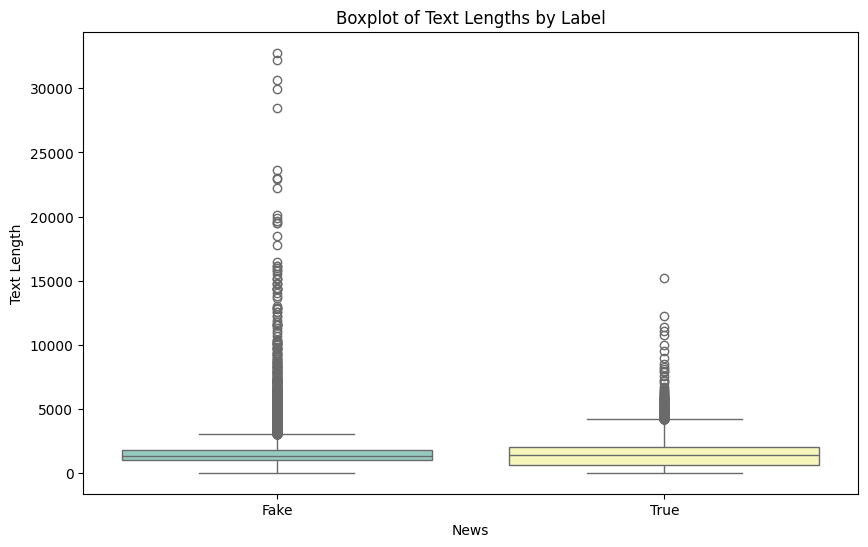

In [12]:
# Boxplot de la longitud de los textos por etiqueta
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='content_length', data=df, palette='Set3')
plt.title('Boxplot of Text Lengths by Label')
plt.xlabel('News')
plt.ylabel('Text Length')
plt.xticks([0, 1], ['Fake', 'True'])
plt.show()

De acuerdo al gráfico Boxplot se puede indicar lo siguiente:

- La mediana (la línea central en el rectángulo del boxplot) de la longitud del Texto cuando la noticia es verdadera es ligeramente mayor en comparación con cuando es falsa. 

- La caja cuando la etiqueta es 1, es decir cuando la noticia es Verdadera es más alta que la otra esto significa que la longitud de los textos es más variable en el grupo de noticias verdaderas en comparación con el otro.

- Existen más valores atípicos cuando la etiqueta es 0, es decir cuando la noticia es Falsa. Esto nos indica que hay algunas noticias falsas con textos excepcionalmente largos o cortos en comparación con las noticias verdaderas.

##### Identificación de Outliers por Tipo de Noticia

In [13]:
# Separando el DataFrame en dos basado en la etiqueta (0 o 1)
df_fake = df[df['label'] == 0]
df_true = df[df['label'] == 1]

# Cálculo del rango interquartílico (IQR) para cada grupo de Noticias
Q1_fake = df_fake['content_length'].quantile(0.25)
Q3_fake = df_fake['content_length'].quantile(0.75)
IQR_fake = Q3_fake - Q1_fake

Q1_true = df_true['content_length'].quantile(0.25)
Q3_true = df_true['content_length'].quantile(0.75)
IQR_true = Q3_true - Q1_true

# Cálculo de límites para identificar outliers
lower_bound_fake = Q1_fake - 1.5 * IQR_fake
upper_bound_fake = Q3_fake + 1.5 * IQR_fake

lower_bound_true = Q1_true - 1.5 * IQR_true
upper_bound_true = Q3_true + 1.5 * IQR_true

# Cantidad de outliers para cada etiqueta
outliers_fake = df_fake[(df_fake['content_length'] < lower_bound_fake) | (df_fake['content_length'] > upper_bound_fake)].shape[0]
outliers_true = df_true[(df_true['content_length'] < lower_bound_true) | (df_true['content_length'] > upper_bound_true)].shape[0]


print(f"Cantidad de outliers para Noticias Falsas (label=0): {outliers_fake}")
print(f"Cantidad de outliers para Noticias Verdaderas (label=1): {outliers_true}")

Cantidad de outliers para Noticias Falsas (label=0): 935
Cantidad de outliers para Noticias Verdaderas (label=1): 335


Con estos resultados se comprobó que existen más valores atípicos cuando la noticia es Falsa  en comparación cuando la noticia es verdadera.

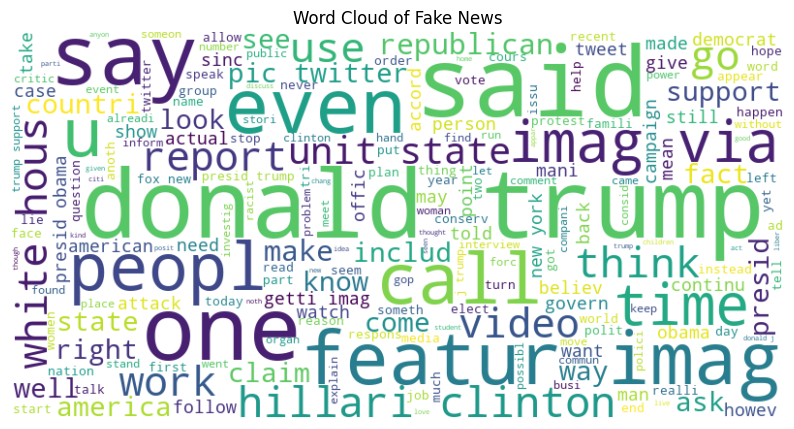

In [14]:
# Palabras más frecuentes en noticias falsas
fake_news_words = ' '.join(df[df['label'] == 0]['content'])
wordcloud_fake = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='white').generate(fake_news_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.title('Word Cloud of Fake News')
plt.axis('off')
plt.show()

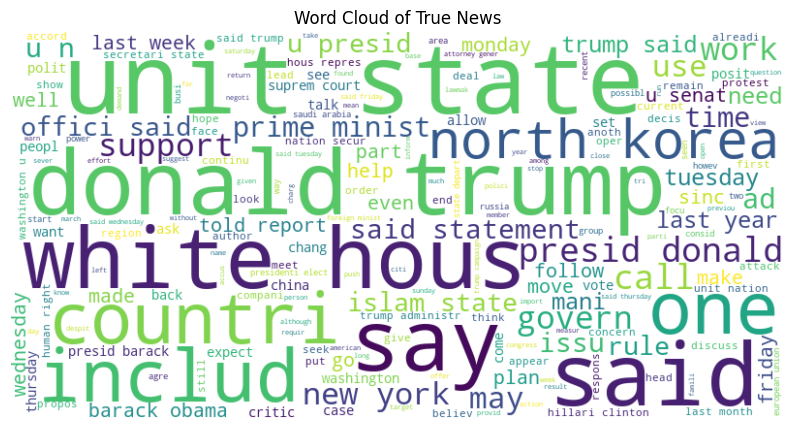

In [15]:
# Palabras más frecuentes en noticias verdaderas
real_news_words = ' '.join(df[df['label'] == 1]['content'])
wordcloud_real = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='white').generate(real_news_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.title('Word Cloud of True News')
plt.axis('off')
plt.show()

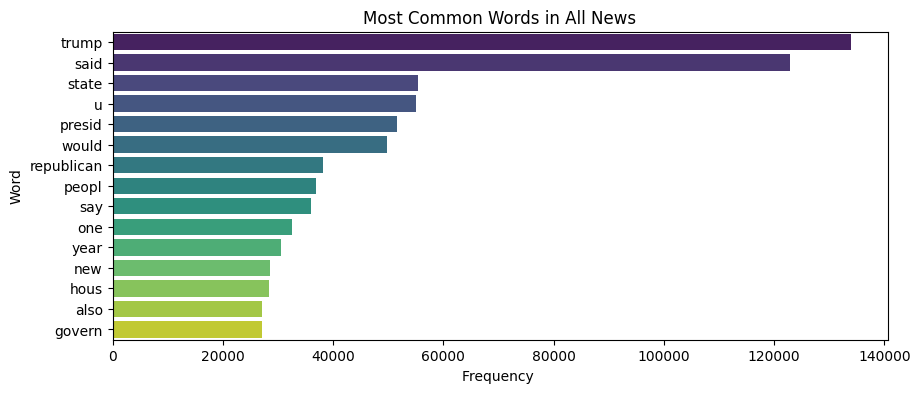

In [16]:
# Palabras más comunes en general
all_words = ' '.join(df['content'])
word_freq = Counter(all_words.split())
common_words = word_freq.most_common(15)


# Visualización de las palabras más comunes
plt.figure(figsize=(10, 4))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words], palette='viridis')
plt.title('Most Common Words in All News')
plt.xlabel('Frequency ')
plt.ylabel('Word')
plt.show()

- Se puede indicar que las noticias estan centradas en temas políticos así como en los discursos relevantes existiendo una inclinación a la cobertura sobre la presidencia y la política estadounidense.